### Antoine EDY
# Natural Language Processing (COMM061) - Coursework

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import nltk
from torch.utils.tensorboard import SummaryWriter

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [3]:
def the_preprocess(df):
    df = pd.DataFrame(df)
    # make everything lowercase
    #df["tokens"] = df["tokens"].apply(lambda x: [i.lower() for i in x])
    # lematize
    lematizer = nltk.WordNetLemmatizer()
    df["tokens"] = df["tokens"].apply(lambda x: [lematizer.lemmatize(i) for i in x])
    #stemming
    #stemmer = nltk.PorterStemmer()
    #df["tokens"] = df["tokens"].apply(lambda x: [stemmer.stem(i) for i in x])

    return df

train_dataset = the_preprocess(dataset["train"])
test_dataset = the_preprocess(dataset["test"])
val_dataset = the_preprocess(dataset["validation"])

In [4]:
lematizer = nltk.WordNetLemmatizer()
sentence = "The striped bats are hanging on their feet for best"
sentence = sentence.split()
sentence = [lematizer.lemmatize(i) for i in sentence]
print(sentence)

['The', 'striped', 'bat', 'are', 'hanging', 'on', 'their', 'foot', 'for', 'best']


In [5]:
stemmer = nltk.PorterStemmer()
sentence = "The striped bats are hanging on their feet for best"
sentence = sentence.split()
sentence = [lematizer.lemmatize(i) for i in sentence]
sentence = [stemmer.stem(i) for i in sentence]
print(sentence)

['the', 'stripe', 'bat', 'are', 'hang', 'on', 'their', 'foot', 'for', 'best']


In [6]:
TEXT2ID = {
    "B-O": 0,
    "B-AC": 1,
    "PAD": 2,
    "B-LF": 3,
    "I-LF": 4,
}
ID2TEXT = {v: k for k, v in TEXT2ID.items()}

print(f"TEXT2ID: {TEXT2ID}\nID2TEXT: {ID2TEXT}\n")

def preprocess(df):
    df = df.drop(columns=['pos_tags'])
    df = df.rename(columns={"ner_tags": "labels"})
    df["ids"] = df["labels"].apply(lambda x: [TEXT2ID[i] for i in x])
    df["sentences"] = df["tokens"].apply(lambda x: " ".join(x))

    return df


train_dataset = preprocess(train_dataset)
test_dataset = preprocess(test_dataset)
val_dataset = preprocess(val_dataset)

train_dataset.info()


# Here the exploration to add at the end of the work.

TEXT2ID: {'B-O': 0, 'B-AC': 1, 'PAD': 2, 'B-LF': 3, 'I-LF': 4}
ID2TEXT: {0: 'B-O', 1: 'B-AC', 2: 'PAD', 3: 'B-LF', 4: 'I-LF'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tokens     1072 non-null   object
 1   labels     1072 non-null   object
 2   ids        1072 non-null   object
 3   sentences  1072 non-null   object
dtypes: object(4)
memory usage: 33.6+ KB


In [7]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, trait, were, m...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological trait were measure...
2,"[Minor, H, antigen, alloimmune, response, read...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune response readily oc...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [8]:
# distribution of labels
all_labels = [label for labels in train_dataset["labels"] for label in labels]

In [9]:
# plot the distribution of labels
print(f"Number of labels: {len(all_labels)}")
print(f"Number of unique labels: {len(set(all_labels))}")
print(f"Labels: {set(all_labels)}")

for i in set(all_labels):
    print(f"Number of {i}: {all_labels.count(i)}")

Number of labels: 40000
Number of unique labels: 4
Labels: {'B-AC', 'B-LF', 'I-LF', 'B-O'}
Number of B-AC: 2336
Number of B-LF: 1462
Number of I-LF: 3231
Number of B-O: 32971


In [10]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1072
126
153


In [11]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, trait, were, m...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological trait were measure...
2,"[Minor, H, antigen, alloimmune, response, read...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune response readily oc...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [12]:
from torchtext.data import Field, Dataset, Example

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True) # Default behaviour is to tokenize by splitting
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

fields = {
    'sentences': ('text', text_field),
    'ids': ('label', label_field)
}

def read_data(df):
    examples = []
    fields = {'sentence_labels': ('labels', label_field),
              'sentence_tokens': ('text', text_field)}
    
    for i in range(len(df)):
        tokens = df['tokens'][i]
        labels = df['labels'][i]
        
        e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                             fields=fields)
        examples.append(e)
    
    return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])


train_data = read_data(train_dataset)
val_data = read_data(val_dataset)
test_data = read_data(test_dataset)

print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(val_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object at 0x32a318730>, 'text': <torchtext.data.field.Field object at 0x32a318ac0>}
['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'wa', 'developed', '.']
['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O']
Train: 1072
Dev: 126
Test: 153


In [13]:
VOCAB_SIZE = 20000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

In [14]:
from torchtext.data import BucketIterator

BATCH_SIZE = 16
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, 
                            sort_key=lambda x: len(x.text), sort_within_batch=True)
val_iter = BucketIterator(dataset=val_data, batch_size=BATCH_SIZE, 
                          sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, 
                           sort_key=lambda x: len(x.text), sort_within_batch=True)

In [15]:
import random
import os
import numpy as np

emb = 'fasttext'

if emb == 'fasttext':

    embedding_matrix = np.load("data/embedding_matrix_fasttext.npy")
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
    #return embedding_matrix

    #embeddings = load_embeddings(EMBEDDING_PATH)
    #embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
    #embedding_matrix = torch.from_numpy(embedding_matrix)
    print(embedding_matrix.shape)

elif emb == 'glove':

    EMBEDDING_PATH = "data/glove.6B.300d.txt"

    def load_embeddings(path):
        """ Load the FastText embeddings from the embedding file. """
        print("Loading pre-trained embeddings")
        
        embeddings = {}
        with open(path) as i:
            for line in i:
                if len(line) > 2: 
                    line = line.strip().split()
                    word = line[0]
                    embedding = np.array(line[1:])
                    embeddings[word] = embedding
        
        return embeddings
        

    def initialize_embeddings(embeddings, vocabulary):
        """ Use the pre-trained embeddings to initialize an embedding matrix. """
        print("Initializing embedding matrix")
        embedding_size = len(embeddings["."])
        embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                    
        for idx, word in enumerate(vocabulary.itos): 
            if word in embeddings:
                embedding_matrix[idx,:] = embeddings[word]
                
        return embedding_matrix

    embeddings = load_embeddings(EMBEDDING_PATH)
    embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
    embedding_matrix = torch.from_numpy(embedding_matrix)
    np.save("glove_embeddings.npy", embedding_matrix)
    print('SAVED')
    embedding_matrix = np.load("glove_embeddings.npy")
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
    print(embedding_matrix.shape)


elif emb == 'word2vec':
    import gensim
    model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)
    em = []
    for word in text_field.vocab.itos:
        if word in model:
            em.append(model.get_vector(word))
        else:
            em.append(np.zeros(300))
    em = np.array(em)
    embedding_matrix = torch.tensor(em, dtype=torch.float32)
    print(embedding_matrix.shape)

torch.Size([9135, 300])


In [16]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

        # 4. Dense Layer
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits

In [17]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, classification_report
from seqeval.metrics import f1_score as seqeval_f1_score

def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES}: {label_field.vocab.itos}")

def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    writer = SummaryWriter()

    # add weight to indexes 3, 4, 5
    w = [0, 0, 0.0443, 0.6259, 1.0000, 0.4525]
    class_weights = torch.tensor(w).to(device)
    criterion = nn.CrossEntropyLoss(weight = class_weights, ignore_index=1)  # we mask the <pad> labels
    # Hinge loss
    # criterion = nn.MultiMarginLoss(margin=1.0, weight=class_weights, reduction='mean')
    
    optimizer = optim.Adam(model.parameters())

    # SGD
    #lr = 0.1
    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # AdamW
    #optimizer = optim.AdamW(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape
            
            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)

        #tensorboard
        writer.add_scalar('train/loss', total_loss, epoch)
        writer.add_scalar('train/precision', train_scores[2], epoch)

        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)

        writer.add_scalar('val/loss', total_loss, epoch)
        writer.add_scalar('val/precision', dev_scores[2], epoch)


        labels = label_field.vocab.itos[2:]
        labels = sorted(labels, key=lambda x: x.split("-")[-1])
        label_idxs = [label_field.vocab.stoi[l] for l in labels]

        cr = classification_report(correct, predictions, labels = label_idxs, target_names=labels, output_dict=True)

        out = {}
        for key in cr.keys():
            if key == 'accuracy':
                out[key] = cr[key]
            else:
                for new_k in ['precision', 'recall', 'f1-score']:
                    out[key+'_'+new_k] = cr[key][new_k]
        
        for (key, value) in out.items():
            writer.add_scalar(f'test/{key}', value, epoch)

        t2id = ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']
        t2id= {i: t2id[i] for i in range(len(t2id))}


        correct = [t2id[i] for i in correct]
        predictions = [t2id[i] for i in predictions]

        # sequeval f1 score
        seqeval_f1 = seqeval_f1_score([correct], [predictions])
        print(seqeval_f1)
        writer.add_scalar('test/seqeval_f1', seqeval_f1, epoch)
        
        
        dev_f = dev_scores[2]

        dev_f = out['macro avg_f1-score']

        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Macro average F1-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

Number of classes: 6: ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


In [18]:
def test(model, test_iter, batch_size, labels, target_names): 
    
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, correct_labels)

        predictions += predicted_labels
        correct += correct_labels
    print(labels, target_names)
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))
    return correct, predictions

In [19]:
import math

EMBEDDING_DIM = 300 #fasttext & word2vec & glove
# EMBEDDING_DIM = 768 #bert
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES} : {label_field.vocab.itos}")
MAX_EPOCHS = 30
PATIENCE = 30

OUTPUT_PATH = "model_saves/adam"

num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  # embeddings
# tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES)  # no embeddings

train_f, dev_f = train(tagger.to(device), train_iter, val_iter, BATCH_SIZE, MAX_EPOCHS, num_batches, PATIENCE, OUTPUT_PATH)

Number of classes: 6 : ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


Epoch 0: 100%|██████████| 67/67 [00:05<00:00, 12.82it/s]


Total training loss: 75.64931660890579
Training performance: (0.38985, 0.38985, 0.38985, None)
Total development loss: 7.0288132429122925
Development performance: (0.4588, 0.4588, 0.4588, None)
0.45939032189298656
Saving model.


Epoch 1: 100%|██████████| 67/67 [00:04<00:00, 13.44it/s]


Total training loss: 44.26745021343231
Training performance: (0.6657, 0.6657, 0.6657, None)
Total development loss: 5.284968942403793
Development performance: (0.6954, 0.6954, 0.6954, None)
0.6967078189300412
Saving model.


Epoch 2: 100%|██████████| 67/67 [00:04<00:00, 13.53it/s]


Total training loss: 36.05354377627373
Training performance: (0.7212, 0.7212, 0.7212, None)
Total development loss: 4.802709639072418
Development performance: (0.7298, 0.7298, 0.7298, None)
0.7329597554763118
Saving model.


Epoch 3: 100%|██████████| 67/67 [00:04<00:00, 14.05it/s]


Total training loss: 32.883445769548416
Training performance: (0.734125, 0.734125, 0.734125, None)
Total development loss: 4.681686103343964
Development performance: (0.7436, 0.7436, 0.7436, None)
0.7426410466067047
Saving model.


Epoch 4: 100%|██████████| 67/67 [00:04<00:00, 15.47it/s]


Total training loss: 29.639846488833427
Training performance: (0.750275, 0.750275, 0.750275, None)
Total development loss: 4.617464333772659
Development performance: (0.7848, 0.7848, 0.7848, None)
0.785323332657612
Saving model.


Epoch 5: 100%|██████████| 67/67 [00:04<00:00, 15.00it/s]


Total training loss: 27.97668208181858
Training performance: (0.759125, 0.759125, 0.759125, None)
Total development loss: 4.301425248384476
Development performance: (0.754, 0.754, 0.754, None)
0.7539118065433855


Epoch 6: 100%|██████████| 67/67 [00:04<00:00, 16.47it/s]


Total training loss: 25.839560568332672
Training performance: (0.7796, 0.7796, 0.7796, None)
Total development loss: 4.317251265048981
Development performance: (0.763, 0.763, 0.763, None)
0.7607939431143851


Epoch 7: 100%|██████████| 67/67 [00:04<00:00, 15.72it/s]


Total training loss: 24.690909057855606
Training performance: (0.778975, 0.778975, 0.778975, None)
Total development loss: 4.304421901702881
Development performance: (0.7814, 0.7814, 0.7814, None)
0.7817848410757946


Epoch 8: 100%|██████████| 67/67 [00:04<00:00, 16.44it/s]


Total training loss: 22.708614885807037
Training performance: (0.789125, 0.789125, 0.789125, None)
Total development loss: 4.257281810045242
Development performance: (0.7894, 0.7894, 0.7894, None)
0.7902815899156247


Epoch 9: 100%|██████████| 67/67 [00:04<00:00, 15.49it/s]


Total training loss: 21.336177453398705
Training performance: (0.804775, 0.804775, 0.804775, None)
Total development loss: 4.230699509382248
Development performance: (0.7816, 0.7816, 0.7816, None)
0.7829433809379114
Saving model.


Epoch 10: 100%|██████████| 67/67 [00:04<00:00, 15.17it/s]


Total training loss: 19.85554776340723
Training performance: (0.815825, 0.815825, 0.815825, None)
Total development loss: 4.274472624063492
Development performance: (0.7772, 0.7772, 0.7772, None)
0.7773607870980829


Epoch 11: 100%|██████████| 67/67 [00:04<00:00, 14.80it/s]


Total training loss: 18.225844740867615
Training performance: (0.818225, 0.818225, 0.818225, None)
Total development loss: 4.746388792991638
Development performance: (0.8032, 0.8032, 0.8032, None)
0.8037003151367288


Epoch 12: 100%|██████████| 67/67 [00:04<00:00, 14.61it/s]


Total training loss: 16.380140148103237
Training performance: (0.83235, 0.83235, 0.83235, None)
Total development loss: 4.502670109272003
Development performance: (0.797, 0.797, 0.797, None)
0.7972438950248253
Saving model.


Epoch 13: 100%|██████████| 67/67 [00:04<00:00, 15.38it/s]


Total training loss: 16.043900407850742
Training performance: (0.83475, 0.83475, 0.83475, None)
Total development loss: 4.55049592256546
Development performance: (0.7844, 0.7844, 0.7844, None)
0.7864008904178893


Epoch 14: 100%|██████████| 67/67 [00:04<00:00, 14.71it/s]


Total training loss: 14.182193048298359
Training performance: (0.849375, 0.849375, 0.849375, None)
Total development loss: 4.913455694913864
Development performance: (0.819, 0.819, 0.819, None)
0.8205596107055962
Saving model.


Epoch 15: 100%|██████████| 67/67 [00:04<00:00, 14.58it/s]


Total training loss: 13.007125556468964
Training performance: (0.8621, 0.8621, 0.8621, None)
Total development loss: 4.9616595804691315
Development performance: (0.811, 0.811, 0.811, None)
0.8126836186809847


Epoch 16: 100%|██████████| 67/67 [00:04<00:00, 15.90it/s]


Total training loss: 12.374584287405014
Training performance: (0.8668, 0.8668, 0.8668, None)
Total development loss: 5.2900711596012115
Development performance: (0.8138, 0.8138, 0.8138, None)
0.815293049530919
Saving model.


Epoch 17: 100%|██████████| 67/67 [00:04<00:00, 14.96it/s]


Total training loss: 10.948261469602585
Training performance: (0.87415, 0.87415, 0.87415, None)
Total development loss: 5.53658601641655
Development performance: (0.8054, 0.8054, 0.8054, None)
0.8058883248730964


Epoch 18: 100%|██████████| 67/67 [00:04<00:00, 15.56it/s]


Total training loss: 10.152053322643042
Training performance: (0.882625, 0.882625, 0.882625, None)
Total development loss: 5.5155995190143585
Development performance: (0.8346, 0.8346, 0.8346, None)
0.8353478923311326


Epoch 19: 100%|██████████| 67/67 [00:04<00:00, 14.00it/s]


Total training loss: 9.047662321478128
Training performance: (0.894375, 0.894375, 0.894375, None)
Total development loss: 6.386237800121307
Development performance: (0.8352, 0.8352, 0.8352, None)
0.8364703501315524


Epoch 20: 100%|██████████| 67/67 [00:05<00:00, 12.20it/s]


Total training loss: 8.026566822081804
Training performance: (0.901775, 0.901775, 0.901775, None)
Total development loss: 6.376000553369522
Development performance: (0.8546, 0.8546, 0.8546, None)
0.858356940509915
Saving model.


Epoch 21: 100%|██████████| 67/67 [00:05<00:00, 11.70it/s]


Total training loss: 7.40768837928772
Training performance: (0.908275, 0.908275, 0.908275, None)
Total development loss: 6.641841262578964
Development performance: (0.8242, 0.8242, 0.8242, None)
0.8249594813614263


Epoch 22: 100%|██████████| 67/67 [00:05<00:00, 12.22it/s]


Total training loss: 7.061038678511977
Training performance: (0.911325, 0.911325, 0.911325, None)
Total development loss: 6.890816152095795
Development performance: (0.8518, 0.8518, 0.8518, None)
0.854055145944854


Epoch 23: 100%|██████████| 67/67 [00:05<00:00, 11.93it/s]


Total training loss: 6.838363379240036
Training performance: (0.91335, 0.91335, 0.91335, None)
Total development loss: 7.478704184293747
Development performance: (0.866, 0.866, 0.866, None)
0.8692493946731233
Saving model.


Epoch 24: 100%|██████████| 67/67 [00:05<00:00, 13.14it/s]


Total training loss: 5.814614461734891
Training performance: (0.923725, 0.923725, 0.923725, None)
Total development loss: 6.884248524904251
Development performance: (0.8276, 0.8276, 0.8276, None)
0.8303869077684615


Epoch 25: 100%|██████████| 67/67 [00:05<00:00, 11.20it/s]


Total training loss: 6.027116933837533
Training performance: (0.9262, 0.9262, 0.9262, None)
Total development loss: 7.873067885637283
Development performance: (0.857, 0.857, 0.857, None)
0.8565345229646153


Epoch 26: 100%|██████████| 67/67 [00:04<00:00, 13.77it/s]


Total training loss: 5.38528891466558
Training performance: (0.9289, 0.9289, 0.9289, None)
Total development loss: 8.135358661413193
Development performance: (0.8722, 0.8722, 0.8722, None)
0.8758697186649189
Saving model.


Epoch 27: 100%|██████████| 67/67 [00:05<00:00, 11.29it/s]


Total training loss: 4.1299127377569675
Training performance: (0.943825, 0.943825, 0.943825, None)
Total development loss: 8.85410663485527
Development performance: (0.849, 0.849, 0.849, None)
0.8515451423954757


Epoch 28: 100%|██████████| 67/67 [00:05<00:00, 11.44it/s]


Total training loss: 4.104940850287676
Training performance: (0.9456, 0.9456, 0.9456, None)
Total development loss: 9.297829031944275
Development performance: (0.87, 0.87, 0.87, None)
0.8733104700423644


Epoch 29: 100%|██████████| 67/67 [00:05<00:00, 11.19it/s]


Total training loss: 3.7231371961534023
Training performance: (0.950775, 0.950775, 0.950775, None)
Total development loss: 9.68272665143013
Development performance: (0.8886, 0.8886, 0.8886, None)
0.892896725440806
Saving model.


In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Data
#df = pd.DataFrame({'epochs': range(0,len(train_f)), 'train_f': train_f, 'val_f': dev_f})
 
# multiple line plot
#plt.plot('epochs', 'train_f', data=df, color='blue', linewidth=2)
#plt.plot('epochs', 'val_f', data=df, color='green', linewidth=2)
#plt.legend()
#plt.show()


In [21]:
%load_ext tensorboard

In [22]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTMTagger(
  (embeddings): Embedding(9135, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=6, bias=True)
)

In [23]:
labels = label_field.vocab.itos[2:]
labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]

c, p = test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = labels)
labels, target_names = [4, 3, 5, 2], ['B-AC', 'I-LF', 'B-LF', 'B-O']

ID2TEXT = dict()
for i in range(len(labels)):
    ID2TEXT[labels[i]] = target_names[i]

c = [ID2TEXT[i] for i in c]
p = [ID2TEXT[i] for i in p]

[4, 3, 5, 2] ['B-AC', 'I-LF', 'B-LF', 'B-O']
              precision    recall  f1-score   support

        B-AC       0.47      0.64      0.54       270
        I-LF       0.60      0.72      0.65       288
        B-LF       0.49      0.59      0.54       150
         B-O       0.96      0.92      0.94      4292

    accuracy                           0.88      5000
   macro avg       0.63      0.72      0.67      5000
weighted avg       0.90      0.88      0.89      5000



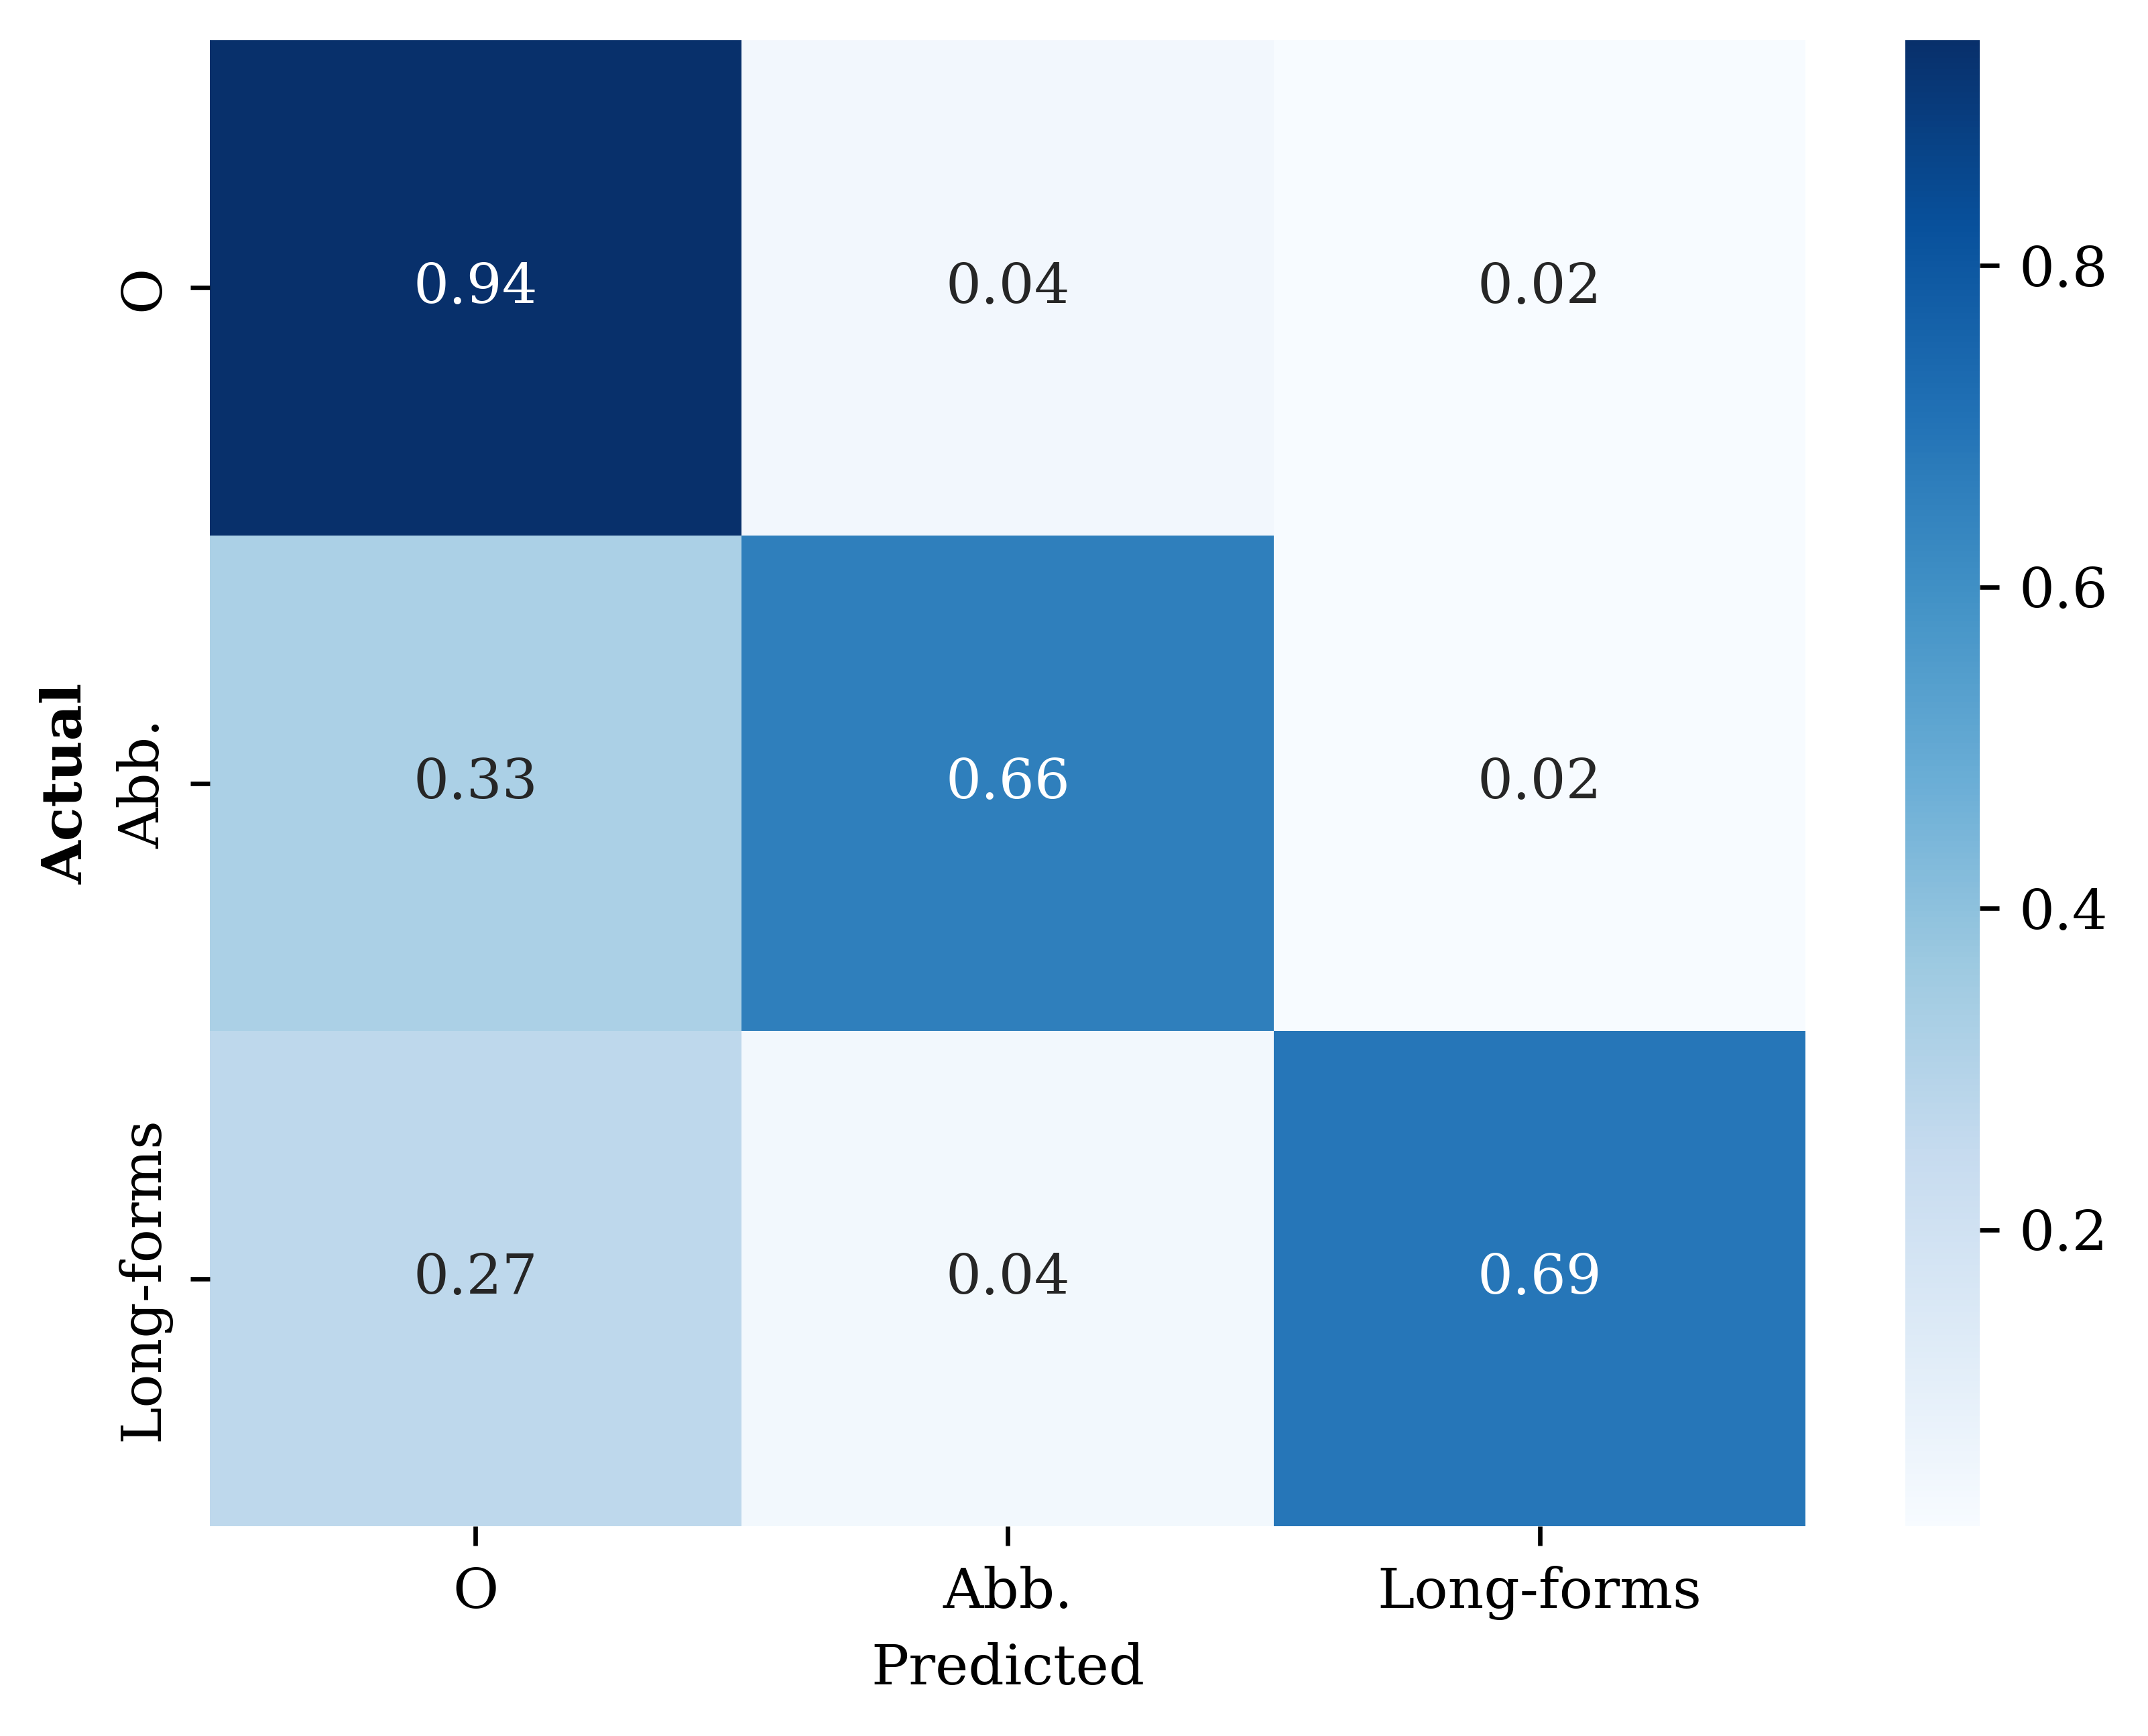

In [24]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['B-O', 'B-AC', 'B-LF']
nlabels = ['O', 'Abb.', 'Long-forms']

cm = confusion_matrix(c, p, normalize='true', labels =labels)

plt.style.use('default')
plt.rcParams['text.usetex'] = False

plt.figure(dpi=600)

# change font to scientific
plt.rcParams['font.family'] = 'serif'

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=nlabels, yticklabels=nlabels, fmt=".2f")
#make labels bold
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted')
plt.show()

In [25]:
from colorama import Back, Style

def vizu(words, output, truth):
    if isinstance(output, torch.Tensor):
        output = output.squeeze().tolist()
    col = {0: Back.GREEN, 1: Back.RED, 2: Back.BLACK, 3: Back.BLUE, 4: Back.MAGENTA}
    colors1 = [col[i] for i in output]
    colors2 = [col[i] for i in truth]
    words = [word.replace("Ġ", "") for word in words]
    print(Style.RESET_ALL + "Output:")
    for i, word in enumerate(words):
        print(colors1[i] + word, end=" ")
    print(Style.RESET_ALL + "\nTruth:")
    for i, word in enumerate(words):
        print(colors2[i] + word, end=" ")